In [9]:
%matplotlib inline
# Implementation of a simple MLP network with one hidden layer. Tested on the iris data set.
# Requires: numpy, sklearn>=0.18.1, tensorflow>=1.0

# NOTE: In order to make the code simple, we rewrite x * W_1 + b_1 = x' * W_1'
# where x' = [x | 1] and W_1' is the matrix W_1 appended with a new row with elements b_1's.
# Similarly, for h * W_2 + b_2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt  
from sklearn import datasets
from sklearn.metrics import confusion_matrix

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [11]:
data.test.labels[0:5,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [12]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])


In [13]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [14]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        

The shape of the training data is such that, each image is a row and since the image is flattened out its 784 columns long. Hence the shape of images reads N,784

In [16]:
data.train.cls = np.array([label.argmax() for label in data.train.labels])

images = data.train.images[41:50]
classes = data.train.cls[41:50]
images[1:3].shape


(2, 784)

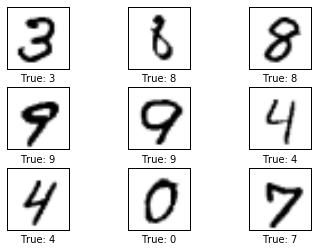

In [17]:

plot_images(images,classes)

In [18]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])
x

<tf.Tensor 'Placeholder:0' shape=(?, 784) dtype=float32>

Here is the fun part now. So x is of size [1,784] for each image. Now for the weights, the weights matrix must multiply the image such that each column of the weight matrix represents a certain class.

Hence the total number of columns must be 10 since there are 10 classes, and the rows represent the size of the image. Suppose your image was 10x10 pixels, then the size of your rows would be 100, the size of the columns would remain the same 

In [126]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))


In [127]:
logits = tf.matmul(x,weights) +biases
logits.shape
y_pred = tf.nn.sigmoid(logits)

Once you have the y_pred what you need to do is get which class has the highest probability hence you can calculate that by -

In [128]:

y_pred_cls = tf.arg_max(y_pred, dimension =1)
y_pred_cls.shape


TensorShape([Dimension(None)])

Below is what is required to execute gradient decesent, you first need to calcuate the cost function, they use an optimizer which will calcuate the gradient desecent. 

In [129]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.7).minimize(cost)


correct_prediction is true if the predicted class and the true class are the same

In [130]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
correct_prediction

<tf.Tensor 'Equal_4:0' shape=(?,) dtype=bool>

In [131]:
session = tf.Session()
session.run(tf.global_variables_initializer())


In [132]:
batch_size = 200
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)


In [133]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}


In [134]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [135]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [136]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [137]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

In [138]:
print_accuracy()


Accuracy on test-set: 9.8%


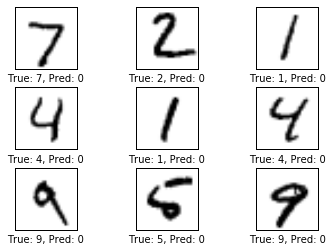

In [139]:
plot_example_errors()


In [140]:
optimize(num_iterations=1)


In [141]:
print_accuracy()


Accuracy on test-set: 39.7%


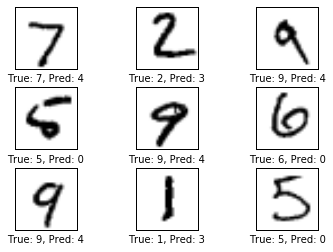

In [143]:
plot_example_errors()


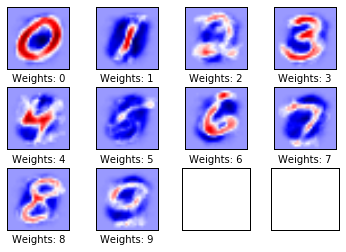

In [144]:
plot_weights()



In [145]:
# We have already performed 1 iteration.
optimize(num_iterations=1000)


In [146]:
print_accuracy()


Accuracy on test-set: 91.9%


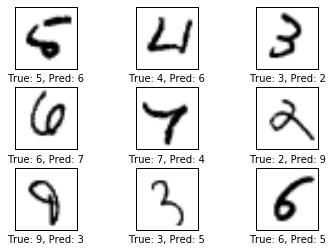

In [82]:
plot_example_errors()


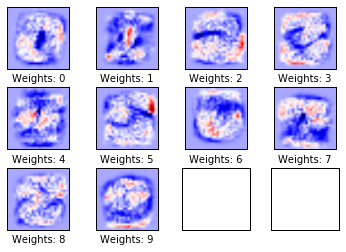

In [83]:
plot_weights()


[[ 963    0    1    3    0    5    6    1    1    0]
 [   0 1108    2    2    1    3    4    2   13    0]
 [   7    9  920   18    7    7   14    9   34    7]
 [   3    1   15  923    0   35    2    8   14    9]
 [   2    2    5    2  900    2   13    3    5   48]
 [   8    1    4   31    5  803   12    3   21    4]
 [  10    3    6    2    5   21  907    3    1    0]
 [   3    6   21   10    7    2    0  941    2   36]
 [   9    8    7   33    7   53   12    9  823   13]
 [  12    6    1   11   17    8    0   13    5  936]]


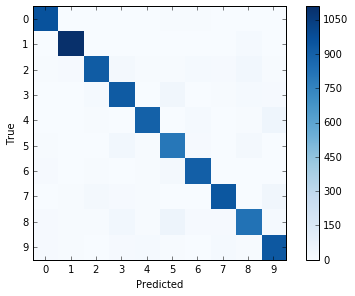

In [84]:
print_confusion_matrix()
